## Post Processing Block

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
numberOfChannels = 8

### Post Processing for epherimis Data Extracting

In [3]:
## Load the saved Tracking result
trackResults = np.load('./trackResults.npy',allow_pickle=True)

In [4]:
trackResults.status

array([b'T', b'T', b'T', b'T', b'T', b'T', b'T', b'T'], dtype='|S1')

In [5]:
def navPartyChk(ndat):
        
        if ndat[1] != 1:
            ndat[2:26] *= (-1)

        # --- Calculate 6 parity bits ----------------------------------------------
        # The elements of the ndat array correspond to the bits showed in the table
        # 20-XIV (ICD-200C document) in the following way:
        # The first element in the ndat is the D29* bit and the second - D30*.
        # The elements 3 - 26 are bits d1-d24 in the table.
        # The elements 27 - 32 in the ndat array are the received bits D25-D30.
        # The array "parity" contains the computed D25-D30 (parity) bits.
        parity = np.zeros(6)
        parity[0] = ndat[0] * ndat[2] * ndat[3] * ndat[4] * ndat[6] * \
                    ndat[7] * ndat[11] * ndat[12] * ndat[13] * ndat[14] * \
                    ndat[15] * ndat[18] * ndat[19] * ndat[21] * ndat[24]

        parity[1] = ndat[1] * ndat[3] * ndat[4] * ndat[5] * ndat[7] * \
                    ndat[8] * ndat[12] * ndat[13] * ndat[14] * ndat[15] * \
                    ndat[16] * ndat[19] * ndat[20] * ndat[22] * ndat[25]

        parity[2] = ndat[0] * ndat[2] * ndat[4] * ndat[5] * ndat[6] * \
                    ndat[8] * ndat[9] * ndat[13] * ndat[14] * ndat[15] * \
                    ndat[16] * ndat[17] * ndat[20] * ndat[21] * ndat[23]

        parity[3] = ndat[1] * ndat[3] * ndat[5] * ndat[6] * ndat[7] * \
                    ndat[9] * ndat[10] * ndat[14] * ndat[15] * ndat[16] * \
                    ndat[17] * ndat[18] * ndat[21] * ndat[22] * ndat[24]

        parity[4] = ndat[1] * ndat[2] * ndat[4] * ndat[6] * ndat[7] * \
                    ndat[8] * ndat[10] * ndat[11] * ndat[15] * ndat[16] * \
                    ndat[17] * ndat[18] * ndat[19] * ndat[22] * ndat[23] * \
                    ndat[25]

        parity[5] = ndat[0] * ndat[4] * ndat[6] * ndat[7] * ndat[9] * \
                    ndat[10] * ndat[11] * ndat[12] * ndat[14] * ndat[16] * \
                    ndat[20] * ndat[23] * ndat[24] * ndat[25]

        # --- Compare if the received parity is equal the calculated parity --------
        if (parity == ndat[26:]).sum() == 6:
            # Parity is OK. Function output is -1 or 1 depending if the data bits
            # must be inverted or not. The "ndat[2]" is D30* bit - the last  bit of
            # previous subframe.
            status = -1 * ndat[1]

        else:
            # Parity failure
            status = 0

        return status


In [6]:
def findPreambles(trackResults):
    # findPreambles finds the first preamble occurrence in the bit stream of
    # each channel. The preamble is verified by check of the spacing between
    # preambles (6sec) and parity checking of the first two words in a
    # subframe. At the same time function returns list of channels, that are in
    # tracking state and with valid preambles in the nav data stream.

    # [firstSubFrame, activeChnList] = findPreambles(trackResults, settings)

    #   Inputs:
    #       trackResults    - output from the tracking function
    #       settings        - Receiver settings.

    #   Outputs:
    #       firstSubframe   - the array contains positions of the first
    #                       preamble in each channel. The position is ms count
    #                       since start of tracking. Corresponding value will
    #                       be set to 0 if no valid preambles were detected in
    #                       the channel.
    #       activeChnList   - list of channels containing valid preambles

    # Preamble search can be delayed to a later point in the tracking results
    # to avoid noise due to tracking loop transients
    searchStartOffset = 0

    # --- Initialize the firstSubFrame array -----------------------------------
    firstSubFrame = np.zeros(len(trackResults), dtype=int)

    # --- Generate the preamble pattern ----------------------------------------
    preamble_bits = np.r_[1, - 1, - 1, - 1, 1, - 1, 1, 1]

    # "Upsample" the preamble - make 20 vales per one bit. The preamble must be
    # found with precision of a sample.
    preamble_ms = np.kron(preamble_bits, np.ones(20))

    # --- Make a list of channels excluding not tracking channels --------------
    activeChnList = (trackResults.status != b'-').nonzero()[0]

    # === For all tracking channels ...
    for channelNr in range(len(activeChnList)):
        # Correlate tracking output with preamble ================================
        # Read output from tracking. It contains the navigation bits. The start
        # of record is skipped here to avoid tracking loop transients.
        bits = trackResults[channelNr].I_P[searchStartOffset:].copy()

        bits[bits > 0] = 1

        bits[bits <= 0] = - 1

        # have to zero pad the preamble so that they are the same length
        tlmXcorrResult = np.correlate(bits,
                                      np.pad(preamble_ms, (0, bits.size - preamble_ms.size), 'constant'),
                                      mode='full')

        # Find all starting points off all preamble like patterns ================
        # clear('index')
        # clear('index2')
        xcorrLength = (len(tlmXcorrResult) + 1) // 2

        index = (np.abs(tlmXcorrResult[xcorrLength - 1:xcorrLength * 2]) > 153).nonzero()[0] + searchStartOffset

        # Analyze detected preamble like patterns ================================
        for i in range(len(index)):
            index2 = index - index[i]

            if (index2 == 6000).any():
                # === Re-read bit vales for preamble verification ==============
                # Preamble occurrence is verified by checking the parity of
                # the first two words in the subframe. Now it is assumed that
                # bit boundaries a known. Therefore the bit values over 20ms are
                # combined to increase receiver performance for noisy signals.
                # in Total 62 bits mast be read :
                # 2 bits from previous subframe are needed for parity checking;
                # 60 bits for the first two 30bit words (TLM and HOW words).
                # The index is pointing at the start of TLM word.
                bits = trackResults[channelNr].I_P[index[i] - 40:index[i] + 20 * 60].copy()

                bits = bits.reshape(20, -1, order='F')

                bits = bits.sum(0)

                bits[bits > 0] = 1

                bits[bits <= 0] = - 1

                if navPartyChk(bits[:32]) != 0 and navPartyChk(bits[30:62]) != 0:
                    # Parity was OK. Record the preamble start position. Skip
                    # the rest of preamble pattern checking for this channel
                    # and process next channel.
                    firstSubFrame[channelNr] = index[i]

                    break
        # Exclude channel from the active channel list if no valid preamble was
        # detected
        if firstSubFrame[channelNr] == 0:
            # Exclude channel from further processing. It does not contain any
            # valid preamble and therefore nothing more can be done for it.
            activeChnList = np.setdiff1d(activeChnList, channelNr)

            print ('Could not find valid preambles in channel %2d !' % channelNr)
    return firstSubFrame, activeChnList

In [7]:
## Obtain each channel data and the starting position of data bits
subFrameStart,activeChnList = findPreambles(trackResults)

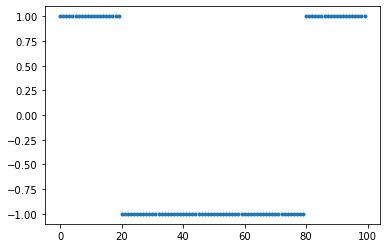

In [8]:
channelNr = 0
bitLoc = subFrameStart[channelNr]
## Clean data Bits
bits = trackResults[channelNr].I_P[bitLoc:].copy()
bits[bits > 0] = 1
bits[bits <= 0] = - 1
plt.plot(bits[:100],'.')

In [9]:
field_str = 'weekNumber,accuracy,health,T_GD,IODC,t_oc,a_f2,a_f1,a_f0,'
field_str += 'IODE_sf2,C_rs,deltan,M_0,C_uc,e,C_us,sqrtA,t_oe,'
field_str += 'C_ic,omega_0,C_is,i_0,C_rc,omega,omegaDot,IODE_sf3,iDot'
eph = np.recarray((32,), formats=['O'] * 27, names=field_str)

In [10]:
channelNr = 0
#for channelNr in activeChnList:
navBitsSamples = trackResults[channelNr].I_P[subFrameStart[channelNr] - 20:
                                                     subFrameStart[channelNr] + 1500 * 20].copy()

In [11]:
navBitsSamples = navBitsSamples.reshape(20, -1, order='F')
navBits = navBitsSamples.sum(0)
navBits = (navBits > 0) * 1

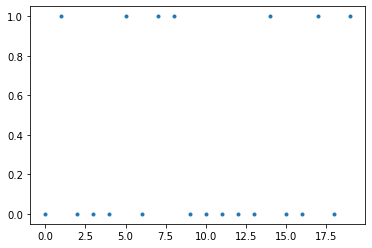

In [12]:
plt.plot(navBits[:20],'.')

In [13]:
import ephemeris

In [14]:
# Decode ephemerides =====================================================
field_str = 'weekNumber,accuracy,health,T_GD,IODC,t_oc,a_f2,a_f1,a_f0,'
field_str += 'IODE_sf2,C_rs,deltan,M_0,C_uc,e,C_us,sqrtA,t_oe,'
field_str += 'C_ic,omega_0,C_is,i_0,C_rc,omega,omegaDot,IODE_sf3,iDot'
eph = np.recarray((32,), formats=['O'] * 27, names=field_str)
for channelNr in activeChnList:
    # === Convert tracking output to navigation bits =======================
    # --- Copy 5 sub-frames long record from tracking output ---------------
    navBitsSamples = trackResults[channelNr].I_P[subFrameStart[channelNr] - 20:
                                                 subFrameStart[channelNr] + 1500 * 20].copy()

    navBitsSamples = navBitsSamples.reshape(20, -1, order='F')

    navBits = navBitsSamples.sum(0)

    # The expression (navBits > 0) returns an array with elements set to 1
    # if the condition is met and set to 0 if it is not met.
    navBits = (navBits > 0) * 1

    # The function ephemeris expects input in binary form. In Matlab it is
    # a string array containing only "0" and "1" characters.
    navBitsBin = list(map(str, navBits))

    eph[trackResults[channelNr].PRN - 1], TOW = ephemeris.ephemeris(navBitsBin[1:], navBitsBin[0])

    if eph[trackResults[channelNr].PRN - 1].IODC is None or \
            eph[trackResults[channelNr].PRN - 1].IODE_sf2 is None or \
            eph[trackResults[channelNr].PRN - 1].IODE_sf3 is None:
        # --- Exclude channel from the list (from further processing) ------
        activeChnList = np.setdiff1d(activeChnList, channelNr)

transmitTime = TOW

In [15]:
TOW

587454

## Obtained Ephemeris Data

In [16]:
eph

rec.array([(None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
           (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
           (1321, 0, 0, -4.190951585769653e-09, 503, 590384, 0.0, 3.296918293926865e-12, 0.00010679662227630615, 85, 42.84375, 4.9302053628427535e-09, 1.6538727585988888, 2.261251211166382e-06, 0.006752743385732174, 1.2351199984550476e-05, 5153.635257720947, 590384, -1.2293457984924316e-07, -0.09233881716237433, 5.960464477539063e-08, 0.9274761104056594, 121.59375, 0.5958616266113392, -8.207127574091831e-09, 85, -3.057270204718485e-10),
           (None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
           (None, None, None, None